# Big Data Platform Group Project
## Amazon Product Reviews Analysis

* Ann Eitrheim
* Alisa Babikova
* Yingkun Zhu

### March 12, 2019



> We want to thank Igor for the completion of this proect. 

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from datetime import datetime
from pyspark.sql.functions import col, udf, split, explode
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Loading the data into Hadoop

In [2]:
#Load data file into HDFS from local directory
#!hdfs dfs -put /home/eitrheim/scratch-midway2/item_dedup.json /user/$USER/data/item_dedup.json

In [3]:
#Load metadata file into HDFS from local directory
#!hdfs dfs -put /home/eitrheim/scratch-midway2/metadata.json /user/$USER/data/metadata.json

In [4]:
#Checking if they are there
!hdfs dfs -ls /user/$USER/data/

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
Found 4 items
-rw-------   3 eitrheim eitrheim  1603186411 2019-02-27 18:27 /user/eitrheim/data/Crimes_-_2001_to_present.csv
-rw-------   3 eitrheim eitrheim        1247 2019-02-28 13:10 /user/eitrheim/data/chi_community_names.csv
-rw-------   3 eitrheim eitrheim 58342134119 2019-02-22 19:26 /user/eitrheim/data/item_dedup.json
-rw-------   3 eitrheim eitrheim 10544467811 2019-03-04 20:17 /user/eitrheim/data/metadata.json


In [5]:
#Making it so Will and Alisa can access my data
#!hdfs dfs -chmod -R a+rX /user/$USER/data/

In [142]:
#Removing access
!hdfs dfs -chmod -R go-rwx /user/$USER/data/

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0


# Loading Spark and data into tables
#### Data is from <http://jmcauley.ucsd.edu/data/amazon/links.html>

In [7]:
spark = SparkSession.builder.appName('amazon').getOrCreate()
sc = spark.sparkContext

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '256g'),
                                        ('spark.app.name', 'Spark Updated Conf'),
                                        ('spark.executor.cores', '16'),
                                        ('spark.cores.max', '16'),
                                        ('spark.driver.memory','256g'),
                                        ("spark.sql.autoBroadcastJoinThreshold", -1),
                                        ("mapreduce.map.memory.mb", -1),
                                        ("mapreduce.reduce.memory.mb", -1),
                                        ("spark.yarn.executor.memoryOverhead", -1),
                                        ("spark.sql.broadcastTimeout", 1200)
                                       ])

In [8]:
# we also tweak spark.sql.autoBroadcastJoinThreshold to -1

from pyspark.sql.functions import broadcast
spark.conf.get("spark.sql.autoBroadcastJoinThreshold")

'10485760'

In [9]:
#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.eventLog.enabled', 'true'),
 ('spark.executor.instances', '4'),
 ('spark.yarn.appMasterEnv.MKL_NUM_THREADS', '1'),
 ('spark.sql.queryExecutionListeners',
  'com.cloudera.spark.lineage.NavigatorQueryListener'),
 ('spark.cores.max', '16'),
 ('spark.executor.memory', '256g'),
 ('spark.lineage.log.dir', '/var/log/spark/lineage'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS',
  'md01.rcc.local,md02.rcc.local'),
 ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
 ('spark.executor.extraLibraryPath',
  '/opt/cloudera/parcels/CDH-6.1.0-1.cdh6.1.0.p0.770702/lib/hadoop/lib/native'),
 ('spark.yarn.historyServer.address', 'http://hd01.rcc.local:18088'),
 ('spark.yarn.executor.memoryOverhead', '-1'),
 ('spark.ui.filters',
  'org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter'),
 ('spark.yarn.jars',
  'local:/opt/cloudera/parcels/CDH-6.1.0-1.cdh6.1.0.p0.770702/lib/spark/jars/*,local:/opt/cloudera/parcels/CDH-6.1.0-1.cdh6.1.0

In [10]:
amazon = spark.read.json("/user/eitrheim/data/item_dedup.json")

In [11]:
metadata = spark.read.json("/user/eitrheim/data/metadata.json")

# Exploring and Formatting the Amazon Reviews table
### This dataset contains product reviews includidng ratings, text, and helpfulness from May 1996 - July 2014
    # file size: 58.34 GB

In [12]:
#Looking at the data before we start to clean it and do feature engineering
amazon.show(2)

+----------+-------+-------+--------------------+-----------+--------------+------------+------------------+--------------+
|      asin|helpful|overall|          reviewText| reviewTime|    reviewerID|reviewerName|           summary|unixReviewTime|
+----------+-------+-------+--------------------+-----------+--------------+------------+------------------+--------------+
|0000000078| [1, 1]|    5.0|Conversations wit...|08 11, 2004|A3AF8FFZAZYNE5|        null|        Impactful!|    1092182400|
|0000000116| [5, 5]|    4.0|Interesting Grish...|04 27, 2002| AH2L9G3DQHHAJ|       chris|Show me the money!|    1019865600|
+----------+-------+-------+--------------------+-----------+--------------+------------+------------------+--------------+
only showing top 2 rows



In [13]:
#Looking at the schema
amazon.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [14]:
#Formatting the reviewTime column
from pyspark.sql.types import DateType

myfunc =  udf(lambda x: datetime.strptime(x, '%m %d, %Y'), DateType())
amazon = amazon.withColumn('reviewTime', myfunc(col('reviewTime')))

In [15]:
#Formatting the asin and overall column
from pyspark.sql.types import IntegerType

amazon = amazon.withColumn("asin", amazon["asin"].cast(IntegerType()))
amazon = amazon.withColumn("overall", amazon["overall"].cast(IntegerType()))

In [16]:
#Formatting the unixReviewTime column
from pyspark.sql.types import TimestampType

amazon = amazon.withColumn('unixReviewTime', F.from_unixtime(col('unixReviewTime')))
amazon = amazon.withColumn('unixReviewTime', F.from_utc_timestamp(col('unixReviewTime'),"Asia/Hong_Kong"))
#assuming the time is based in Hong Kong (dates come up a day behind the reviewTime otherwise)
#the guy who we got access to the data source was at student/researcher/teacher(?) in Hong Kong at this time

amazon = amazon.withColumn("unixReviewTime", amazon["unixReviewTime"].cast(TimestampType()))
amazon.filter(amazon.overall == 1).select('reviewTime', 'unixReviewTime').show(4)

+----------+-------------------+
|reviewTime|     unixReviewTime|
+----------+-------------------+
|2014-03-24|2014-03-24 03:00:00|
|2013-01-07|2013-01-07 02:00:00|
|2014-04-27|2014-04-27 03:00:00|
|2013-03-21|2013-03-21 03:00:00|
+----------+-------------------+
only showing top 4 rows



In [17]:
#Newest date in the dataset
amazon.agg({"unixReviewTime": "max"}).collect()[0][0]

datetime.datetime(2014, 7, 23, 3, 0)

In [18]:
#Oldest date in the dataset
amazon.agg({"unixReviewTime": "min"}).collect()[0][0]

datetime.datetime(1996, 5, 20, 3, 0)

In [19]:
#Dropping the unixReviewTime column as it provides no additional information
amazon = amazon.drop("unixReviewTime")

In [20]:
#Dropping the reviewerName column since we have reviewerID
amazon = amazon.drop("reviewerName")

In [21]:
print(" The amazon dataframe has {:,} records".format(amazon.count()))

 The amazon dataframe has 82,677,139 records


In [22]:
#Dropping rows without an asin
amazon = amazon.filter(amazon.asin.isNotNull())

In [23]:
print(" The amazon dataframe has {:,} records".format(amazon.count()))

 The amazon dataframe has 18,289,296 records


In [24]:
#Adding an unique identifier to the columns
amazon = amazon.withColumn('reviewID', F.monotonically_increasing_id())

In [25]:
#Spliting the helpful column into two columns
#Using posexplode to do that
amazon = amazon.select("reviewID","asin",'overall','reviewText','reviewTime','reviewerID','summary','helpful',F.posexplode("helpful"))
amazon = amazon.withColumn('helpfulVote', F.when((col("pos") == 0), col("col")).otherwise(0))
amazon = amazon.filter(amazon.pos != 0)
amazon = amazon.withColumn("totalVotes",amazon.col).drop("col")
amazon = amazon.select("reviewID","asin",'overall','reviewText','reviewTime','reviewerID','summary','helpful','totalVotes',F.posexplode("helpful"))
amazon = amazon.filter(amazon.pos != 1)
amazon = amazon.drop("pos")
amazon = amazon.withColumn("helpfulVotes",amazon.col).drop("col")
amazon = amazon.drop("helpful")

In [26]:
#unique users and how many things they have recommended
amazon.groupBy("reviewerID").count().sort("count", ascending=[0]).show(6)

+--------------+-----+
|    reviewerID|count|
+--------------+-----+
|A14OJS0VWMOSWO|38555|
|   AFVQZQ8PW0L|25712|
|A2F6N60Z96CAJI| 5599|
|A2OJW07GQRNJUT| 4114|
|A1S3C5OFU508P3| 4019|
|A1X8VZWTOG8IS6| 3883|
+--------------+-----+
only showing top 6 rows



In [27]:
print(" The amazon dataframe has {:,} unique reviewers".format(amazon.groupBy("reviewerID").count().sort("count", ascending=[0]).count()))

 The amazon dataframe has 7,261,083 unique reviewers


In [28]:
print(" The amazon dataframe has {:,} unique products".format(amazon.select('asin').distinct().count()))

 The amazon dataframe has 1,725,046 unique products


In [29]:
#Descriptive statistics on the ratings and helpfulness
amazon.select('overall','totalVotes','helpfulVotes').describe().show()

+-------+------------------+-----------------+-----------------+
|summary|           overall|       totalVotes|     helpfulVotes|
+-------+------------------+-----------------+-----------------+
|  count|          18289296|         18289296|         18289296|
|   mean|  4.30385767718998|4.224146079761627|3.008134430106003|
| stddev|1.1112010401159533| 20.3455942935767| 17.2911368753149|
|    min|                 1|                0|                0|
|    max|                 5|            24212|            23311|
+-------+------------------+-----------------+-----------------+



Text(0.5,1,'Distribution of Ratings Given')

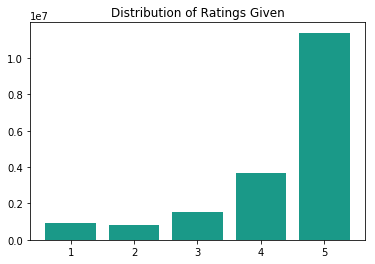

In [30]:
#Plotting the distribution of ratings given to a prodcut 
df1 = amazon.groupBy("overall").count()
pdf = df1.toPandas()
pdf = pdf.sort_values(by='overall')
index = (['1','2','3','4','5'])
plt.bar(pdf.overall, pdf['count'],color='#1a9988')
plt.title('Distribution of Ratings Given')

Text(0.5,1,'Distribution of Number of Helpful Votes Recieved')

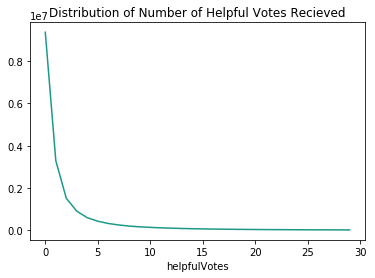

In [31]:
#Plotting the distribution of how many helpful votes a review has gotten
df1 = amazon.groupBy('helpfulVotes').count()
pdf = df1.toPandas()
pdf = pdf.sort_values(by='helpfulVotes')
pdf.index = pdf.helpfulVotes
pdf['count'].head(30).plot(color='#1a9988')
plt.title('Distribution of Number of Helpful Votes Recieved')

# Exploring and Formatting the Amazon Metadata table
### Metadata includes descriptions, price, sales-rank, brand info, and co-purchasing links
    # file size: 10.54 GB

In [32]:
#Printing the schema of the metadata
metadata.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- description: string (nullable = true)
 |-- imUrl: string (nullable = true)
 |-- price: double (nullable = true)
 |-- related: struct (nullable = true)
 |    |-- also_bought: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- also_viewed: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- bought_together: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- buy_after_viewing: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |-- salesRank: struct (nullable = true)
 |    |-- Appliances: long (nullable = true)
 |    |-- Arts, Crafts & Sewing: long (nullable = true)
 |    |-- Automotive: long

In [33]:
#Looking at the first two rows
metadata.show(2)

+---------------+----------+-----+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|_corrupt_record|      asin|brand|          categories|         description|               imUrl|price|             related|           salesRank|               title|
+---------------+----------+-----+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|           null|0001048791| null|           [[Books]]|                null|http://ecx.images...| null|                null|[,,,,, 6334800,,,...|The Crucible: Per...|
|           null|0000143561| null|[[Movies & TV, Mo...|3Pack DVD set - I...|http://g-ecx.imag...|12.99|[, [B0036FO6SI, B...|[,,,,,,,,,,,,,,,,...|Everyday Italian ...|
+---------------+----------+-----+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------

In [34]:
print(" The metadata dataframe has {:,} records".format(metadata.count()))

 The metadata dataframe has 9,430,088 records


In [35]:
#Dropping rows without an asin
metadata = metadata.filter(metadata.asin.isNotNull())

In [36]:
print(" The metadata dataframe has {:,} records".format(metadata.count()))

 The metadata dataframe has 8,403,388 records


In [37]:
#Dropping image URL column as we will not be using it
metadata = metadata.drop("imUrl")

In [38]:
#Dropping _corrupt_record column as it is now all nulls due to dropping Null asins
metadata = metadata.drop("_corrupt_record")

In [39]:
#Dropping related column as we will not be using it
metadata = metadata.drop("related")

In [40]:
metadata.show(2)

+----------+-----+--------------------+--------------------+-----+--------------------+--------------------+
|      asin|brand|          categories|         description|price|           salesRank|               title|
+----------+-----+--------------------+--------------------+-----+--------------------+--------------------+
|0001048791| null|           [[Books]]|                null| null|[,,,,, 6334800,,,...|The Crucible: Per...|
|0000143561| null|[[Movies & TV, Mo...|3Pack DVD set - I...|12.99|[,,,,,,,,,,,,,,,,...|Everyday Italian ...|
+----------+-----+--------------------+--------------------+-----+--------------------+--------------------+
only showing top 2 rows



In [41]:
#Looking into the nested data
metadata.filter(metadata.salesRank.Appliances.isNotNull()).show(1, truncate=False)

+----------+------+-----------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+--------------------------------------+-------------------------------------------+
|asin      |brand |categories                                                                                     |description                                                                                                                                                                                                                        |price|salesRank                             |title                                      |
+----------+------+-----------------------------------------------------------------------------------------------+-------------------

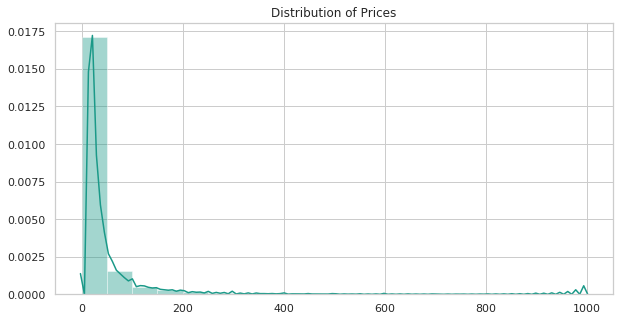

In [42]:
data = metadata.filter(metadata.price.isNotNull())
data = data.select("price")
pdf = data.toPandas()

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.distplot(pdf, color='#1a9988', kde=True, bins=20).set_title("Distribution of Prices")

# Merging data sources

In [43]:
#Picking columns we will use from the datasets
df1 = metadata.select("asin","title",'price')
df2 = amazon.select("asin",'overall','reviewText','summary',
                    'reviewerID','helpfulVotes','totalVotes') 

In [44]:
#Merging into a new table
df = df2.join(df1, 'asin')

In [45]:
#Dropping rows without a title
df = df.filter(df.title.isNotNull())

In [46]:
print(" The combined dataframe has {:,} records".format(df.count()))

 The combined dataframe has 13,451,898 records


In [47]:
#Dropping rows without a title
df = df.dropna()

In [48]:
print(" The combined dataframe has {:,} records".format(df.count()))

 The combined dataframe has 12,762,877 records


In [49]:
#Removing hierarchy and collecting an item's main category
df1 = metadata.select("asin",'categories')
df1 = df1.select("asin",(F.posexplode('categories')))
df1 = df1.filter(df1.pos == 0)
df1 = df1.drop('pos')
df1 = df1.withColumn('categories',df1.col)
df1 = df1.drop('col')
df1 = df1.select("asin",(F.posexplode('categories')))
df1 = df1.filter(df1.pos == 0)
df1 = df1.drop('pos')
df1 = df1.withColumn('mainCategory',df1.col)
df1 = df1.drop('col')

#Merging mainCategory to our combined dataframe
df = df.join(df1, 'asin')

In [50]:
from pyspark.sql.functions import regexp_replace

df = df.withColumn('mainCategory', regexp_replace('mainCategory', 'Amazon Fashion', 'Clothing, Shoes & Jewelry'))
df = df.withColumn('mainCategory', regexp_replace('mainCategory', 'All Beauty', 'Beauty'))
df = df.withColumn('mainCategory', regexp_replace('mainCategory', 'Computers', 'Electronics'))
df = df.withColumn('mainCategory', regexp_replace('mainCategory', 'All Electronics', 'Electronics'))
df = df.withColumn('mainCategory', regexp_replace('mainCategory', 'Office & School Supplies', 'Office Products'))
df = df.withColumn('mainCategory', regexp_replace('mainCategory', 'Baby Products', 'Baby'))

In [51]:
df = df.filter(df.mainCategory != '')

In [52]:
#Removing items with no category
df = df.filter(df.mainCategory.isNotNull())

In [53]:
df.groupBy("mainCategory").count().orderBy(["count"], ascending=[0]).show(28, truncate = False)

+-------------------------+--------+
|mainCategory             |count   |
+-------------------------+--------+
|Books                    |12431819|
|Movies & TV              |292552  |
|Toys & Games             |18180   |
|CDs & Vinyl              |7206    |
|Office Products          |2474    |
|Arts, Crafts & Sewing    |1966    |
|Electronics              |1471    |
|Home & Kitchen           |1255    |
|Tools & Home Improvement |796     |
|Sports & Outdoors        |465     |
|Health & Personal Care   |360     |
|Clothing, Shoes & Jewelry|351     |
|Cell Phones & Accessories|178     |
|Baby                     |162     |
|Pet Supplies             |158     |
|Musical Instruments      |101     |
|Industrial & Scientific  |72      |
|Software                 |62      |
|Beauty                   |35      |
|Patio, Lawn & Garden     |23      |
|Video Games              |7       |
|Grocery & Gourmet Food   |6       |
|Home Improvement         |5       |
|Automotive               |3       |
+

In [54]:
# #Removing hierarchy and collecting an item's subcategory
# df1 = metadata.select("asin",'categories')
# df1 = df1.select("asin",(F.posexplode('categories')))
# df1 = df1.drop('pos')
# df1 = df1.withColumn("categories",df1.col).drop('col')
# df1 = df1.select("asin",F.posexplode('categories'))
# df1 = df1.withColumn("categories",df1.col).drop('col')
# df1 = df1.dropDuplicates()
# df1 = df1.withColumn('subCategory',df1.categories).drop('categories')
# df2 = df1.groupBy("asin").max()
# df3 = df1.join(df2, 'asin')
# df3 = df3.withColumn('maxPos',col('max(pos)')).drop('max(pos)','pos')
# df3 = df3.dropDuplicates()
# df3 = df3.drop('maxPos')

# #Merging subCategory to our combined dataframe
# df = df.join(df3, 'asin')

In [55]:
itemAverageRating = df.select('asin','overall').groupBy("asin").mean()
itemAverageRating = itemAverageRating.withColumn("aveRating",col("avg(overall)")).drop('avg(overall)','avg(asin)')
df = df.join(itemAverageRating, 'asin')

In [56]:
print(" The combined dataframe has {:,} records".format(df.count()))

 The combined dataframe has 12,759,707 records


In [57]:
#Seeing what our dataframe that we will use for ML looks like
df.show(2)

+-------+-------+--------------------+--------------------+--------------+------------+----------+---------------+-----+------------+---------+
|   asin|overall|          reviewText|             summary|    reviewerID|helpfulVotes|totalVotes|          title|price|mainCategory|aveRating|
+-------+-------+--------------------+--------------------+--------------+------------+----------+---------------+-----+------------+---------+
|2218321|      5|Written in 1969, ...|An early Forbes c...|A3KXFQQFBPJTQE|           1|         3|Tramp in Armour| 54.9|       Books|      4.5|
|2218321|      4|The events in the...|  Races along nicely|A3LFKLALXW7XTL|           1|         2|Tramp in Armour| 54.9|       Books|      4.5|
+-------+-------+--------------------+--------------------+--------------+------------+----------+---------------+-----+------------+---------+
only showing top 2 rows



In [58]:
#Most reviewed products
df.groupBy("asin",'title','aveRating').count().sort("count", ascending=[0]).show(5, truncate = False)

+---------+-----------------------------------------------+-----------------+-----+
|asin     |title                                          |aveRating        |count|
+---------+-----------------------------------------------+-----------------+-----+
|439023483|The Hunger Games (The Hunger Games, Book 1)    |4.644406019254136|21398|
|439023513|Mockingjay (The Final Book of The Hunger Games)|4.232676774833498|14114|
|385537859|Inferno                                        |3.918985585446697|12973|
|7444117  |Allegiant (Divergent, #3)                      |3.350542402407158|12629|
|375831002|The Book Thief                                 |4.623737172858165|12571|
+---------+-----------------------------------------------+-----------------+-----+
only showing top 5 rows



# Machine Learning Models

### === Some more dataframe transformation to enable better ML===

#### main dataframe for ML purpose

* reviews = a subset of df, complete length
    1. reviewText tokenized into feature 
    2. overall rating converted to binary (0 or 1) label
    3. helpfulVotes into high, medium, low buckets
    4. splited into train and test w. 80/20 ratio

In [59]:
# sample a much smaller set for easier processing
df_sample = df.sample(False, 0.1, 0) # replacement, fraction, seed

In [60]:
df_sample.count()

1275699

In [61]:
#Manually remove these RDDs instead of waiting for it to fall out of the cache
df.unpersist()
amazon.unpersist()
metadata.unpersist()
df1.unpersist()
df2.unpersist()

from pyspark.sql import SparkSession
spark.catalog.clearCache()

from pyspark.sql import SQLContext
sqlContext.clearCache()

In [62]:
# create a subset only contains necessary info, from df
reviews = df_sample[["reviewText", "overall", "helpfulVotes"]]

In [63]:
#Manually remove the RDD not being used
df_sample.unpersist()

DataFrame[asin: int, overall: int, reviewText: string, summary: string, reviewerID: string, helpfulVotes: bigint, totalVotes: bigint, title: string, price: double, mainCategory: string, aveRating: double]

In [64]:
reviews.head(3)

[Row(reviewText='This tiny set is perfect for little hands to hold to look at the colorful pictures. A good set to introduce Paddinton Bear to baby.', overall=5, helpfulVotes=2),
 Row(reviewText="I've run conferences and forums (at a high level-cabinet ministers and the like), and am always looking for ways to keep the agenda and presentations interesting and relevant.  &#34;Will there be Donuts?&#34; is more focused on every day meetings, but the main themes of what to do and what not to do, and how to control a meeting, are just as relevant to me.", overall=4, helpfulVotes=0),
 Row(reviewText="Having sat through too many terrible meetings in my life, I was hoping that this book would offer me advice as a manager towards conducting meetings in a more effective and interesting manner.  Unfortunately, apart from some interesting anecdotes, I had trouble deriving a lot of value from the book itself.  Many of Pearl's examples are from non-profits and government agencies, and some of the a

In [65]:
reviews.show(5)

+--------------------+-------+------------+
|          reviewText|overall|helpfulVotes|
+--------------------+-------+------------+
|This tiny set is ...|      5|           2|
|I've run conferen...|      4|           0|
|Having sat throug...|      3|           0|
|This book took a ...|      4|           0|
|Meetings are the ...|      5|           0|
+--------------------+-------+------------+
only showing top 5 rows



In [66]:
# Step 1: convert overall score 

#Define positive rating as the score larger or equal to 4 ->1
#Define negative rating as the score lower than 4 ->0

def transform(star):
    if star >=4:
        return 1
    else:
        return 0
transformer = udf(transform)

In [67]:
sqlContext.registerDataFrameAsTable(reviews, "table2")
reviews1 = sqlContext.sql("SELECT reviewText, overall from table2 LIMIT 50000")

In [68]:
#use transformer function to convert 0-5 scoring into 0/1
temp1 = reviews1.withColumn("label", transformer(reviews['overall']))

temp1 = temp1.withColumn("label", temp1["label"].cast(IntegerType()))

In [69]:
sqlContext.registerDataFrameAsTable(temp1, "table1")
temp2 = sqlContext.sql("SELECT reviewText, label from table1 WHERE reviewText != ''")

In [70]:
reviews2 = temp2.join(reviews, 'reviewText')

In [71]:
# Step 2: transform helpfulVotes
# Feature Engineering
from pyspark.ml.feature import QuantileDiscretizer

# 3-Buckets: High Medium Low
discretizer = QuantileDiscretizer(numBuckets=3, 
                                  inputCol="helpfulVotes", 
                                  outputCol="hvcat")

In [72]:
reviews2 = discretizer.fit(reviews2).transform(reviews2)

In [73]:
reviews2.show(5)

+--------------+-----+-------+------------+-----+
|    reviewText|label|overall|helpfulVotes|hvcat|
+--------------+-----+-------+------------+-----+
|     Very Good|    1|      5|           0|  1.0|
|    Great read|    1|      5|           0|  1.0|
|     very good|    1|      5|           0|  1.0|
|Excellent book|    1|      5|           0|  1.0|
|     good book|    1|      5|           0|  1.0|
+--------------+-----+-------+------------+-----+
only showing top 5 rows



In [74]:
# Step 3: reviewText operation
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

#Tokenize words
tokenizer = Tokenizer(inputCol="reviewText",outputCol="words")
reviews2 = tokenizer.transform(reviews2)

In [75]:
#drop the redundant source column
reviews2 = reviews2.drop("reviewText")

In [76]:
from pyspark.ml.feature import StopWordsRemover

#remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
reviews2 = remover.transform(reviews2)

In [77]:
reviews2.show(5)

+-----+-------+------------+-----+-----------------+-----------------+
|label|overall|helpfulVotes|hvcat|            words|         filtered|
+-----+-------+------------+-----+-----------------+-----------------+
|    1|      5|           0|  1.0|           [good]|           [good]|
|    1|      5|           0|  1.0|           [good]|           [good]|
|    1|      5|           0|  1.0|           [good]|           [good]|
|    1|      5|           0|  1.0|[excellent, book]|[excellent, book]|
|    1|      5|           0|  1.0|     [good, read]|     [good, read]|
+-----+-------+------------+-----+-----------------+-----------------+
only showing top 5 rows



In [78]:
#drop the redundant source column
reviews = reviews.drop("words")

In [79]:
#Maps a sequence of terms to their term frequencies using the hashing trick. 
#alternatively, CountVectorizer can also be used to get term frequency vectors
hashingTF = HashingTF(inputCol="filtered", 
                      outputCol="rawFeatures", 
                      numFeatures=20)
featurizedData = hashingTF.transform(reviews2)

In [81]:
#Inverse document frequency
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
nlpdf = idfModel.transform(featurizedData)

In [82]:
#Spilting into train and test sets
splits = nlpdf.randomSplit([0.8, 0.2], seed=0)
train_df = splits[0]
test_df = splits[1]

In [83]:
train_df = train_df.repartition(8)

In [84]:
train_df.show(5)

+-----+-------+------------+-----+--------------------+--------------------+--------------------+--------------------+
|label|overall|helpfulVotes|hvcat|               words|            filtered|         rawFeatures|            features|
+-----+-------+------------+-----+--------------------+--------------------+--------------------+--------------------+
|    0|      3|           0|  1.0|                [ok]|                [ok]|      (20,[4],[1.0])|(20,[4],[0.285274...|
|    1|      5|           0|  1.0|   [excellent, read]|   [excellent, read]|(20,[1,10],[1.0,1...|(20,[1,10],[0.371...|
|    1|      5|           0|  1.0|      [great, book!]|      [great, book!]|(20,[0,16],[1.0,1...|(20,[0,16],[0.217...|
|    1|      4|           0|  1.0|[a, good, book, l...|[good, book, like...|(20,[0,1,2,4,5,7,...|(20,[0,1,2,4,5,7,...|
|    1|      5|           0|  1.0|[it's, been, a, l...|[long, time, sinc...|(20,[0,2,4,5,7,11...|(20,[0,2,4,5,7,11...|
+-----+-------+------------+-----+--------------

# 1. Using features to predict on helpfulVotes. 

## 1.1 Logistic Regression

In [86]:
from pyspark.ml.classification import LogisticRegression

# Set parameters for Logistic Regression
lgr1 = LogisticRegression(maxIter=10, featuresCol = 'features', labelCol='hvcat')

# Fit the model to the data.
lgr1m = lgr1.fit(train_df)

# Given a dataset, predict each point's label, and show the results.
predictions1 = lgr1m.transform(test_df)

In [87]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#print evaluation metrics
evaluator = MulticlassClassificationEvaluator(labelCol="hvcat", predictionCol="prediction")

In [88]:
print(evaluator.evaluate(predictions1, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(predictions1, {evaluator.metricName: "f1"}))

0.6374007936507936
0.6123122006176439


# 1.2 Naive Bayes

In [89]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(labelCol="hvcat",featuresCol="features",smoothing=1)
nbm = nb.fit(train_df)
nb_pred = nbm.transform(test_df)

In [90]:
evaluator = MulticlassClassificationEvaluator(labelCol="hvcat", predictionCol="prediction")

In [92]:
print(evaluator.evaluate(nb_pred, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(nb_pred, {evaluator.metricName: "f1"}))

0.04564606741573034
0.06806673294260514


The model is not useful so we will not use it for the next use case

## 1.3.a Random Forest

In [93]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [120]:
# Train a RandomForest model.
rf1 = RandomForestClassifier(labelCol="hvcat", featuresCol="features", numTrees=10, seed=10)
rf1m = rf1.fit(train_df)
rf1_pred = rf1m.transform(test_df)

In [121]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="hvcat", predictionCol="prediction")

In [123]:
print(evaluator.evaluate(rf1_pred, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(rf1_pred, {evaluator.metricName: "f1"}))

0.6577491702705421
0.6571631121047004


## 1.3.b Random Forest

In [129]:
#Setting the model's parameters
rf2 = RandomForestClassifier(labelCol="hvcat",featuresCol="features", numTrees=100, maxDepth = 4, maxBins = 32, seed=0)

In [130]:
#Training the model
rf2m = rf2.fit(train_df)

In [131]:
#Getting predictions
rf2_pred = rf2m.transform(test_df)

In [132]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="hvcat", predictionCol="prediction")

In [133]:
print(evaluator.evaluate(rf2_pred, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(rf2_pred, {evaluator.metricName: "f1"}))

0.6539935160624816
0.6568514576807893


# 2. Using features to predict label a.k.a. overall rating

## 2.1 Logistic Regression

In [134]:
from pyspark.sql.types import IntegerType

train_df = train_df.withColumn("label", train_df["label"].cast(IntegerType()))
test_df = test_df.withColumn("label", test_df["label"].cast(IntegerType()))

In [135]:
from pyspark.ml.classification import LogisticRegression
lgr2 = LogisticRegression(maxIter=4, featuresCol = 'features', labelCol='label')

In [136]:
#Training the model
lgr2 = lgr2.fit(train_df)

In [138]:
#Getting predictions
predictions2 = lgr2.transform(test_df)

In [139]:
predictions2.show(3)

+-----+-------+------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|label|overall|helpfulVotes|hvcat|               words|            filtered|         rawFeatures|            features|       rawPrediction|         probability|prediction|
+-----+-------+------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|    1|      5|           0|  1.0|      [great, book!]|      [great, book!]|(20,[0,16],[1.0,1...|(20,[0,16],[0.217...|[-1.8261782234372...|[0.13869418527874...|       1.0|
|    1|      5|           0|  1.0|       [thank, you!]|       [thank, you!]|      (20,[2],[2.0])|(20,[2],[0.922327...|[-1.7974021575244...|[0.14216759287541...|       1.0|
|    0|      1|           0|  1.0|[how, many, times...|[many, times, man...|(20,[3,4,5,6,8,9,...|(20,[3,4,5,6,8,9,...|[-1.6848324901995...|[

In [140]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#print evaluation metrics
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

In [141]:
print(evaluator.evaluate(predictions2, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(predictions2, {evaluator.metricName: "f1"}))

0.8301018409714062
0.7498163875668206


## 2.2.a Random Forest

In [103]:
#Setting the parameters
rf3 = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

In [105]:
#Training the model
rf3m = rf3.fit(train_df)

In [106]:
#Getting predictions
rf3_pred = rf3m.transform(test_df)

In [107]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

In [108]:
print(evaluator.evaluate(rf3_pred, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(rf3_pred, {evaluator.metricName: "f1"}))

0.8279408827641302
0.7575298892087614


## 2.2.b Random Forest

In [109]:
#Setting the parameters
rf4 = RandomForestClassifier(labelCol="label",featuresCol="features", numTrees=100, maxDepth = 4, maxBins = 32)

In [110]:
#Training the model
rf4m = rf4.fit(train_df)

In [111]:
#Getting predictions
rf4_pred = rf4m.transform(test_df)

In [112]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

In [115]:
print(evaluator.evaluate(rf4_pred, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(rf4_pred, {evaluator.metricName: "f1"}))

0.8233205090263391
0.75349929786199


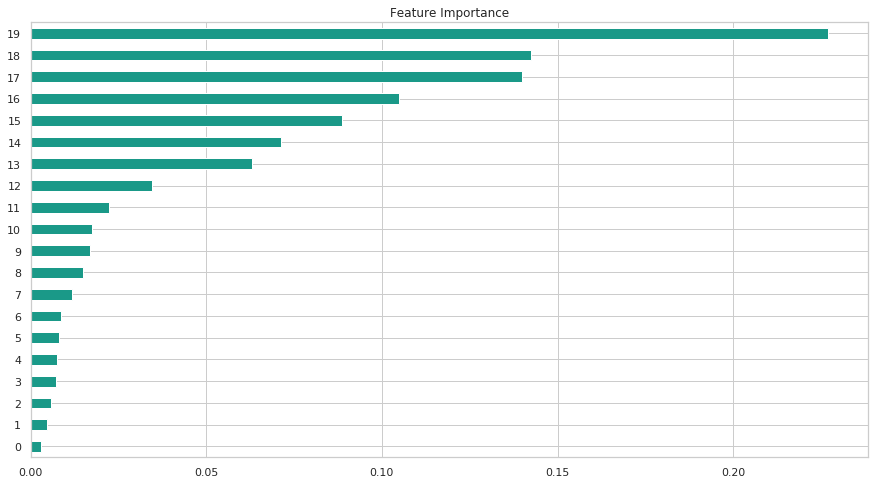

In [116]:
# Create a pd.Series of features importances
sortedimportance = pd.Series(sorted(rf4m.featureImportances))
plt.figure(figsize=(15, 8))
sortedimportance.plot(kind='barh', color='#1a9988')
plt.title("Feature Importance")
plt.show()

## The END